In [58]:
import lightgbm as lgbm
import numpy as np
import sklearn
import pandas as pd
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle

# Прогноз вероятности совершения заказа клиентами в период с 01.11.11 по 30.11.11

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи:" data-toc-modified-id="Описание-задачи:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи:</a></span></li><li><span><a href="#Пайплайн-решения-задачи:" data-toc-modified-id="Пайплайн-решения-задачи:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Пайплайн решения задачи:</a></span></li><li><span><a href="#Возможное-применение-бизнесом-результатов-этого-исследования:" data-toc-modified-id="Возможное-применение-бизнесом-результатов-этого-исследования:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Возможное применение бизнесом результатов этого исследования:</a></span></li><li><span><a href="#Ознакомление-с-данными-и-предобработка" data-toc-modified-id="Ознакомление-с-данными-и-предобработка-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Ознакомление с данными и предобработка</a></span><ul class="toc-item"><li><span><a href="#Создаем-тренировочную-и-тестовую-выборки,-где-объект---это-клиент,-а-признаками-являются-факт-совержения-покупки-в-определенный-месяц-года" data-toc-modified-id="Создаем-тренировочную-и-тестовую-выборки,-где-объект---это-клиент,-а-признаками-являются-факт-совержения-покупки-в-определенный-месяц-года-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создаем тренировочную и тестовую выборки, где объект - это клиент, а признаками являются факт совержения покупки в определенный месяц года</a></span></li></ul></li><li><span><a href="#Обучение-моделей:" data-toc-modified-id="Обучение-моделей:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей:</a></span><ul class="toc-item"><li><span><a href="#Обоснование-выбора-модели-и-метрики-качества" data-toc-modified-id="Обоснование-выбора-модели-и-метрики-качества-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Обоснование выбора модели и метрики качества</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#UPSAMPLING" data-toc-modified-id="UPSAMPLING-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>UPSAMPLING</a></span></li><li><span><a href="#Выбираем-первый-вариант-данных-(без-upsampling)-и-сохраняем-ответы" data-toc-modified-id="Выбираем-первый-вариант-данных-(без-upsampling)-и-сохраняем-ответы-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Выбираем первый вариант данных (без upsampling) и сохраняем ответы</a></span></li></ul></li><li><span><a href="#Рекомендации-относительно-перспектив-дальнейшего-исследования-этого-массива-данных:" data-toc-modified-id="Рекомендации-относительно-перспектив-дальнейшего-исследования-этого-массива-данных:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Рекомендации относительно перспектив дальнейшего исследования этого массива данных:</a></span></li></ul></div>

## Описание задачи:

- В тренировачной выборке train_data.csv содержатся данные о продажах магазина в период с 01.12.10 по 31.10.11.
- Для каждого клиента, который делал заказ в период с 01.12.10 по 31.10.11, необходимо спрогнозировать вероятность совершения заказа в период с 01.11.11 по 30.11.11.


## Пайплайн решения задачи:

1. Предобработка данных:\
• получение общей информации о датасете, вывод статистик.\
• изменение типов данных, группировка по клиентам.\
• удаление выбросов и пропущенных значений в датасете.\
• Создание нового датафрейма для обучения моделей.
2. Обучение различных моделей, с учетом дисбаланса классов в
гиперпараметре моделей, а также с помощью техники Upsampling, сравнение
полученных метрик.
3. Выбор наилучшей модели и сохранение таблицы с ответами.

## Возможное применение бизнесом результатов этого исследования:
- Оптимизация привоза/хранения товара на складе.
- Прогнозирование прибыли от продаж товаров.
- Рассылка клиентам с прогнозом «1» дополнительны. рекомендаций с целью увеличить чек.
- Рассылка клиентам с прогнозом «0» маркетинговых предложений с целью склонения к покупке/ повышения лояльности клиента.
    

## Ознакомление с данными и предобработка

In [4]:
df = pd.read_csv('/Users/a1234/Downloads/train_data.csv', sep=';') #, parse_dates=[4]
df.head()

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01.12.10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01.12.10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.10 8:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431673 entries, 0 to 431672
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     431673 non-null  object 
 1   ProductID     431673 non-null  object 
 2   Name          430309 non-null  object 
 3   Quantity      431673 non-null  int64  
 4   InvoiceDate   431673 non-null  object 
 5   PricePerItem  431673 non-null  float64
 6   CustomerID    323570 non-null  float64
 7   Country       431673 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 26.3+ MB


Text(0.5, 0, 'Quantity')

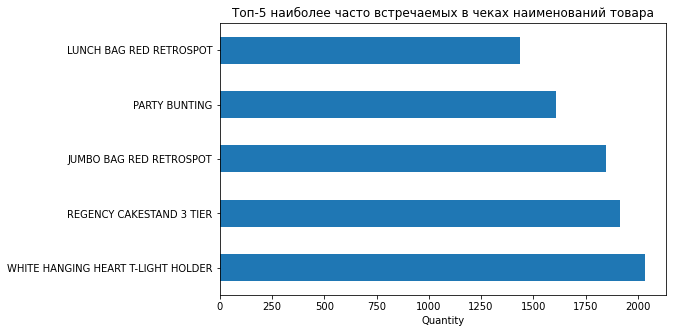

In [64]:
df['Name'].value_counts().head().plot(kind='barh')
plt.title('Топ-5 наиболее часто встречаемых в чеках наименований товара')
plt.xlabel('Quantity')

In [78]:
df['total'] = df['Quantity']*df['PricePerItem']

Text(0.5, 0, 'Revenue')

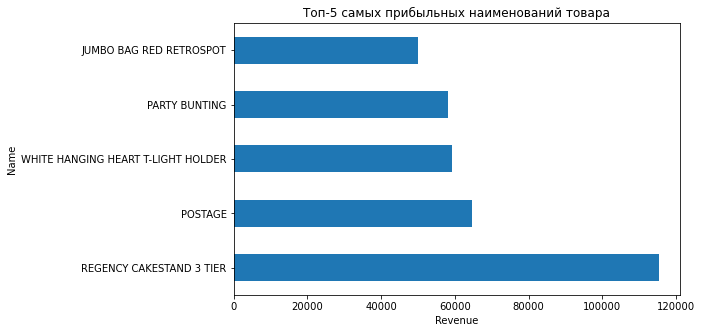

In [87]:
df.groupby('Name')['total'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Топ-5 самых прибыльных наименований товара')
plt.xlabel('Revenue')

Подавляющее большиство покупок происходит в Соединенном Королевстве, отднако интересно взглянуть на список остальных стран:

Text(0.5, 0, 'Quantity')

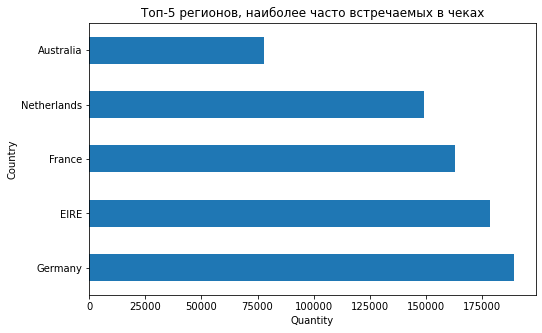

In [88]:
df[df['Country']!='United Kingdom'].groupby('Country')['total'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Топ-5 регионов, наиболее часто встречаемых в чеках')
plt.xlabel('Quantity')

In [71]:
#Производим замену типов данных:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d.%m.%y', exact=False)
df['CustomerID'] = df['CustomerID'].astype('object')
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

In [72]:
print('Число периодов-месяцев:', len(df['InvoiceMonth'].unique()))

Число периодов-месяцев: 11


Text(0.5, 0, 'Revenue')

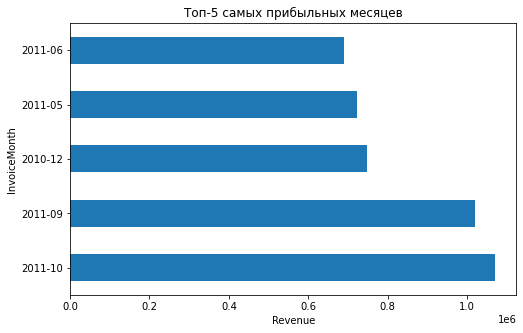

In [80]:
df.groupby('InvoiceMonth')['total'].sum().sort_values(ascending=False).head().plot(kind='barh')
plt.title('Топ-5 самых прибыльных месяцев')
plt.xlabel('Revenue')

In [81]:
df.describe(include='all')

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country,InvoiceMonth,total
count,431673,431673,430309,431673.000000,431673,431673.000000,323570.0,431673,431673,431673.000000
unique,21423,4019,4129,NaN,271,NaN,4010.0,38,11,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2010-12-06 00:00:00,NaN,17841.0,United Kingdom,2011-10,NaN
freq,1114,1981,2033,NaN,3878,NaN,6087.0,392912,60742,NaN
first,NaN,NaN,NaN,NaN,2010-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.752361,NaN,4.720560,NaN,NaN,NaN,18.190444
std,NaN,NaN,NaN,169.271211,NaN,101.414028,NaN,NaN,NaN,214.916106
min,NaN,NaN,NaN,-74215.000000,NaN,-11062.060000,NaN,NaN,NaN,-77183.600000
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,NaN,NaN,NaN,3.750000


In [82]:
df = df.set_index('InvoiceDate')

In [83]:
df = df.dropna(subset=['CustomerID'])
df.head()

,InvoiceNo,ProductID,Name,Quantity,PricePerItem,CustomerID,Country,InvoiceMonth,total
InvoiceDate,,,,,,,,,
2010-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12,15.30
2010-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12,20.34
2010-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12,22.00
2010-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12,20.34
2010-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12,20.34


Очищаем данные от записей, где не указан ID клиента:

In [84]:
df['CustomerID'].value_counts()

17841.0    6087
14911.0    4645
14096.0    2700
12748.0    2643
14606.0    2400
           ... 
14351.0       1
13120.0       1
16990.0       1
16995.0       1
16579.0       1
Name: CustomerID, Length: 4010, dtype: int64

Удаляем аномальные данные о количестве товара:

In [85]:
low = 1
high = df['Quantity'].quantile(0.99)

df = df[(df['Quantity']>= low) & (df['Quantity']<= high)]

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 312902 entries, 2010-12-01 to 2011-10-31
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype    
---  ------        --------------   -----    
 0   InvoiceNo     312902 non-null  object   
 1   ProductID     312902 non-null  object   
 2   Name          312902 non-null  object   
 3   Quantity      312902 non-null  int64    
 4   PricePerItem  312902 non-null  float64  
 5   CustomerID    312902 non-null  object   
 6   Country       312902 non-null  object   
 7   InvoiceMonth  312902 non-null  period[M]
 8   total         312902 non-null  float64  
dtypes: float64(2), int64(1), object(5), period[M](1)
memory usage: 23.9+ MB


Группируем число покупок каждого клиента по месячным периодам:

In [86]:
c = df.groupby(['CustomerID', 'InvoiceMonth'])['Quantity'].count()
c

CustomerID  InvoiceMonth
12347.0     2010-12         31
            2011-01         29
            2011-04         23
            2011-06         18
            2011-08         22
                            ..
18283.0     2011-07         57
            2011-09         47
            2011-10         40
18287.0     2011-05         29
            2011-10         41
Name: Quantity, Length: 10656, dtype: int64

### Создаем тренировочную и тестовую выборки, где объект - это клиент, а признаками являются факт совержения покупки в определенный месяц года

In [12]:
customers = df['CustomerID'].unique()

In [13]:
r = pd.Series(pd.date_range(start='2010-12', end='2011-11', freq='M')).dt.to_period('M')
v = pd.DataFrame(index = customers, columns=r)

In [14]:
for i in v.index:
    for j in v.columns:
        try:
            if c.loc[i, str(j)] >0:
                v.loc[i, j] = int(1)
        except:
            v.loc[i, j] = int(0)

In [15]:
v

,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10
17850.0,1,0,0,0,0,0,0,0,0,0,0
13047.0,1,0,1,1,0,1,1,0,1,0,1
12583.0,1,1,1,1,0,1,1,1,1,1,1
13748.0,1,0,0,0,1,0,0,0,0,1,0
15100.0,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13651.0,0,0,0,0,0,0,0,0,0,0,1
12552.0,0,0,0,0,0,0,0,0,0,0,1
16127.0,0,0,0,0,0,0,0,0,0,0,1
12588.0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
X = v.iloc[:, : 10].astype('int')
y = v.iloc[:, 10].astype('int')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2958, 10), (986, 10), (2958,), (986,))

## Обучение моделей:

### Обоснование выбора модели и метрики качества

• Были попробованы модели: деревья решений, случайный лес,
Light GBM.

• Метрикой качества выбрана F1, как наилучшая в условиях
дисбаланса классов. Дополнительно рассматривалась метрика
recall.

• Выбрана модель случайный лес, т.к. она показывает как высокое
значение метрики F1, так и метрики recall.


$$
F1 score = 2 * \frac{recall * precision}{recall + precision}
$$

In [19]:
def eval(model, params):
    grid = GridSearchCV(model, param_grid=params, scoring='f1', n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_test)                                                   
    f1 = f1_score(y_test, pred)
    print('F_1:', grid.best_score_)
    print('Best params:',grid.best_params_)

### Decision Tree

In [20]:
%%time
model = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
eval(model, {'max_depth': [range(4, 20, 2), None], 'criterion': ['gini', 'entropy'] ,
             'min_samples_split': np.arange(2, 26, 2), 'min_samples_leaf': np.arange(1, 10, 1)})

F_1: 0.6093586296700524
Best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 24}
CPU times: user 1.3 s, sys: 149 ms, total: 1.45 s
Wall time: 4.54 s


### Random Forest

In [21]:
%%time
model = RandomForestClassifier(class_weight='balanced', random_state=12345, n_estimators=300, n_jobs=-1)
eval(model, {'max_depth': [range(4, 20, 2), None], 'criterion': ['gini', 'entropy']})

F_1: 0.5828171278984587
Best params: {'criterion': 'gini', 'max_depth': None}
CPU times: user 880 ms, sys: 273 ms, total: 1.15 s
Wall time: 3.35 s


In [22]:
%%time
model = RandomForestClassifier(class_weight='balanced', random_state=12345,
                               criterion= 'gini', n_estimators=300, n_jobs=-1)
eval(model, {'min_samples_split': np.arange(2, 26, 2)})

F_1: 0.6104362973913423
Best params: {'min_samples_split': 22}
CPU times: user 910 ms, sys: 262 ms, total: 1.17 s
Wall time: 11.6 s


In [23]:
%%time
model = RandomForestClassifier(min_samples_split=22, class_weight='balanced', random_state=12345,
                               criterion= 'gini', n_estimators=300, n_jobs=-1)
eval(model, {'min_samples_leaf': np.arange(1, 10, 1)})

F_1: 0.6194986877053015
Best params: {'min_samples_leaf': 9}
CPU times: user 884 ms, sys: 262 ms, total: 1.15 s
Wall time: 8.89 s


### LGBM

In [24]:
%%time
model = LGBMClassifier(class_weight='balanced', n_estimators=300, random_state=12345, n_jobs=-1)
eval(model, {'learning_rate':np.arange(0.01, 0.99, 0.2)})

F_1: 0.6100725695750115
Best params: {'learning_rate': 0.01}
CPU times: user 1.6 s, sys: 23.1 ms, total: 1.62 s
Wall time: 2.93 s


In [25]:
%%time
model = LGBMClassifier(learning_rate=0.01, class_weight='balanced', n_estimators=100, random_state=12345, n_jobs=-1)
eval(model, {'num_leaves':np.arange(10, 100, 1)})

F_1: 0.6129072983615529
Best params: {'num_leaves': 16}
CPU times: user 1.45 s, sys: 133 ms, total: 1.58 s
Wall time: 8.06 s


In [26]:
from sklearn.metrics import confusion_matrix
model = RandomForestClassifier(min_samples_leaf=9, min_samples_split=22, class_weight='balanced', random_state=12345,
                               criterion= 'gini', n_estimators=300, n_jobs=-1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test, predictions))

[[537 103]
 [130 216]]


Text(33.0, 0.5, 'True lable')

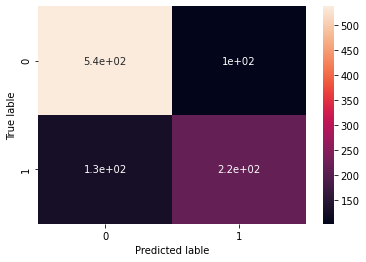

In [27]:
ax = sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
ax.set_xlabel('Predicted lable')
ax.set_ylabel('True lable')

In [28]:
def ROC(model, X, y):

    probabilities = model.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y, probabilities)

    plt.figure()

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()

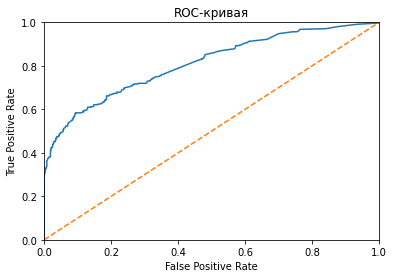

In [29]:
ROC(model, X_test, y_test)

In [30]:
def PR(model, X, y):

    probabilities = model.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)

    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show() 

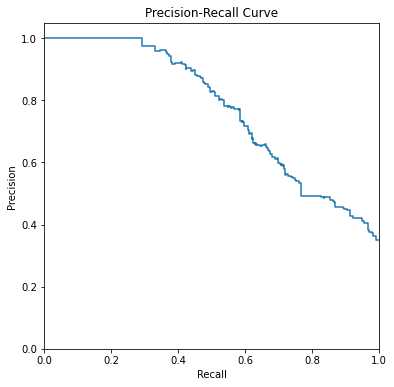

In [31]:
PR(model, X_test, y_test)

In [32]:
def f_t(model, X, y):
    thresholds = np.linspace(0, 1, 100)
    probabilities = model.predict_proba(X)[:,1]
    scores = [f1_score(y, (probabilities > t).astype(np.int)) for t in thresholds]
    plt.plot(thresholds, scores, label='F-score');
    plt.scatter(thresholds[np.argmax(scores)], np.max(scores), label='Maximum')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('F-score')
    plt.title('F-score for unbalanced dataset')

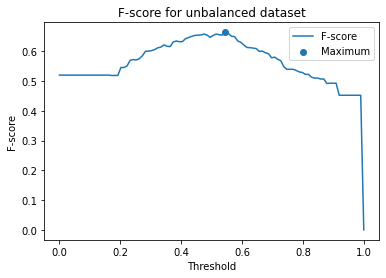

In [33]:
f_t(model, X_test, y_test)

In [34]:
def th(model, X, y):
    probabilities = model.predict_proba(X)[:,1]
    for threshold in np.arange(0, 1, 0.05):
        predicted = probabilities > threshold   
        precision = precision_score(y, predicted)
        recall =  recall_score(y, predicted)
        f1 = f1_score(y, predicted)
        print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(
            threshold, precision, recall, f1))

In [35]:
th(model, X_test, y_test)

Threshold = 0.00 | Precision = 0.351, Recall = 1.000, F1-score = 0.520
Threshold = 0.05 | Precision = 0.351, Recall = 1.000, F1-score = 0.520
Threshold = 0.10 | Precision = 0.351, Recall = 1.000, F1-score = 0.520
Threshold = 0.15 | Precision = 0.351, Recall = 1.000, F1-score = 0.520
Threshold = 0.20 | Precision = 0.378, Recall = 0.980, F1-score = 0.545
Threshold = 0.25 | Precision = 0.407, Recall = 0.968, F1-score = 0.573
Threshold = 0.30 | Precision = 0.453, Recall = 0.896, F1-score = 0.602
Threshold = 0.35 | Precision = 0.487, Recall = 0.844, F1-score = 0.618
Threshold = 0.40 | Precision = 0.561, Recall = 0.720, F1-score = 0.630
Threshold = 0.45 | Precision = 0.633, Recall = 0.673, F1-score = 0.653
Threshold = 0.50 | Precision = 0.677, Recall = 0.624, F1-score = 0.650
Threshold = 0.55 | Precision = 0.771, Recall = 0.584, F1-score = 0.664
Threshold = 0.60 | Precision = 0.828, Recall = 0.500, F1-score = 0.623
Threshold = 0.65 | Precision = 0.878, Recall = 0.457, F1-score = 0.601
Thresh

### UPSAMPLING

In [36]:
y.value_counts()

0    2589
1    1355
Name: 2011-10, dtype: int64

In [37]:
def upsample(features, target, repeat):
    features_0 = features[target==0]
    features_1 = features[target==1]
    target_0 =  target[target==0]
    target_1 =  target[target==1]
    features_upsampled = pd.concat( [features_0] + [features_1]*repeat)
    target_upsampled = pd.concat( [target_0] + [target_1]*repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [38]:
repeat = math.ceil(y[y==0].shape[0]/y[y==1].shape[0])
repeat

2

In [39]:
X_train, y_train = upsample(X_train, y_train, repeat)
X_train.shape, y_train.shape

((3967, 10), (3967,))

In [40]:
%%time
model = DecisionTreeClassifier(random_state=12345)
eval(model, {'max_depth': [range(4, 20, 2), None], 'criterion': ['gini', 'entropy'] ,
             'min_samples_split': np.arange(2, 26, 2), 'min_samples_leaf': np.arange(1, 10, 1)})

F_1: 0.6937537390346116
Best params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
CPU times: user 1.18 s, sys: 78.9 ms, total: 1.26 s
Wall time: 2.31 s


In [41]:
%%time
model = RandomForestClassifier(random_state=12345, n_estimators=300, n_jobs=-1)
eval(model, {'max_depth': [range(4, 20, 2), None], 'criterion': ['gini', 'entropy']})

F_1: 0.7068459203260208
Best params: {'criterion': 'entropy', 'max_depth': None}
CPU times: user 1.12 s, sys: 280 ms, total: 1.4 s
Wall time: 3.43 s


In [42]:
%%time
model = RandomForestClassifier(random_state=12345,
                               criterion= 'entropy', n_estimators=300, n_jobs=-1)
eval(model, {'min_samples_split': np.arange(2, 26, 2)})

F_1: 0.7068459203260208
Best params: {'min_samples_split': 2}
CPU times: user 1.32 s, sys: 300 ms, total: 1.62 s
Wall time: 13.3 s


In [43]:
%%time
model = RandomForestClassifier(random_state=12345,
                               criterion= 'entropy', n_estimators=300, n_jobs=-1)
eval(model, {'min_samples_leaf': np.arange(1, 40, 2)})

F_1: 0.7068459203260208
Best params: {'min_samples_leaf': 1}
CPU times: user 1.38 s, sys: 280 ms, total: 1.66 s
Wall time: 23.4 s


In [44]:
%%time
model = LGBMClassifier(n_estimators=300, random_state=12345, n_jobs=-1)
eval(model, {'learning_rate':np.arange(0.01, 0.99, 0.2)})

F_1: 0.7099166009930166
Best params: {'learning_rate': 0.81}
CPU times: user 1.57 s, sys: 28.4 ms, total: 1.6 s
Wall time: 1.57 s


In [45]:
%%time
model = LGBMClassifier(learning_rate=0.61, class_weight='balanced', n_estimators=300, random_state=12345, n_jobs=-1)
eval(model, {'num_leaves':np.arange(10, 20, 1)})

F_1: 0.7063116194971585
Best params: {'num_leaves': 17}
CPU times: user 1.18 s, sys: 72.7 ms, total: 1.25 s
Wall time: 1.56 s


In [46]:
%%time
model = LGBMClassifier(learning_rate=0.61, class_weight='balanced', n_estimators=300, random_state=12345, n_jobs=-1)
eval(model, {'reg_lambda':np.arange(0, 20, 1)})

F_1: 0.7045912452597405
Best params: {'reg_lambda': 4}
CPU times: user 2.08 s, sys: 111 ms, total: 2.19 s
Wall time: 4.69 s


In [47]:
%%time
model = LGBMClassifier(random_state=12345, learning_rate=0.61, n_jobs=-1, n_estimators=300)
eval(model, {'reg_alpha':np.arange(0, 10, 1)})

F_1: 0.7080411554859418
Best params: {'reg_alpha': 0}
CPU times: user 1.76 s, sys: 74 ms, total: 1.83 s
Wall time: 983 ms


In [48]:
model = LGBMClassifier(learning_rate=0.61, class_weight='balanced', n_estimators=300, random_state=12345, n_jobs=-1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test, predictions))

[[530 110]
 [157 189]]


Text(33.0, 0.5, 'True lable')

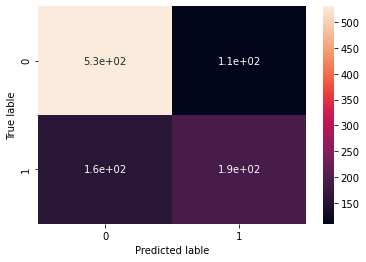

In [49]:
ax = sns.heatmap(confusion_matrix(y_test, predictions), annot=True)
ax.set_xlabel('Predicted lable')
ax.set_ylabel('True lable')

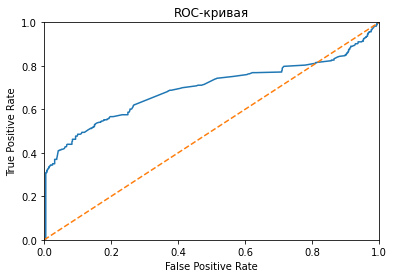

In [50]:
ROC(model, X_test, y_test)

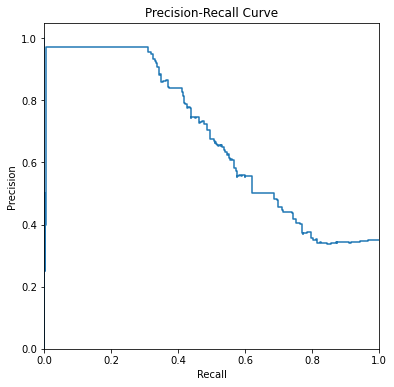

In [51]:
PR(model, X_test, y_test)

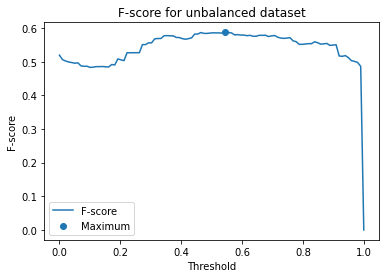

In [52]:
f_t(model, X_test, y_test)

In [53]:
th(model, X_test, y_test)

Threshold = 0.00 | Precision = 0.351, Recall = 1.000, F1-score = 0.520
Threshold = 0.05 | Precision = 0.343, Recall = 0.893, F1-score = 0.496
Threshold = 0.10 | Precision = 0.338, Recall = 0.850, F1-score = 0.483
Threshold = 0.15 | Precision = 0.342, Recall = 0.832, F1-score = 0.485
Threshold = 0.20 | Precision = 0.375, Recall = 0.789, F1-score = 0.508
Threshold = 0.25 | Precision = 0.402, Recall = 0.766, F1-score = 0.527
Threshold = 0.30 | Precision = 0.458, Recall = 0.708, F1-score = 0.556
Threshold = 0.35 | Precision = 0.498, Recall = 0.688, F1-score = 0.578
Threshold = 0.40 | Precision = 0.559, Recall = 0.587, F1-score = 0.573
Threshold = 0.45 | Precision = 0.615, Recall = 0.555, F1-score = 0.584
Threshold = 0.50 | Precision = 0.632, Recall = 0.546, F1-score = 0.586
Threshold = 0.55 | Precision = 0.648, Recall = 0.538, F1-score = 0.588
Threshold = 0.60 | Precision = 0.658, Recall = 0.517, F1-score = 0.579
Threshold = 0.65 | Precision = 0.690, Recall = 0.494, F1-score = 0.576
Thresh

### Выбираем первый вариант данных (без upsampling) и сохраняем ответы

In [54]:
model = RandomForestClassifier(min_samples_leaf=9, min_samples_split=22, 
                               class_weight='balanced', random_state=12345,
                               criterion= 'gini', n_estimators=300, n_jobs=-1)
model.fit(X, y)
prob = model.predict_proba(v.iloc[:, 1:11].astype('int'))[:,1]

In [55]:
answer =  pd.DataFrame({'CustomerID': list(customers), 'prob': list(prob)})
answer.to_csv('/Users/a1234/Downloads/answer.csv')

## Рекомендации относительно перспектив дальнейшего исследования этого массива данных:

- Возможно провести исследовательский анализ данных, выявить наиболее/наименее популярные продаваемые товары.
- Исследовать временные ряды по суммарным чекам от всех клиентов с разбивкой по наименованиям товара.
- Построить модель, которая делает предсказания о покупке конкретного наименования товара клиентом.
- Провести кластеризацию клиентов по типу (базовый, продвинутый, премиальный), а также по предпочтениям товаров.